<a href="https://colab.research.google.com/github/AgapovKS/pet_projects/blob/main/pet_project_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание оттока пользователей



## Description

Это соревнование является домашним заданием к 3 модулю продвинутого потока DLS Необходимо моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы. В качестве ответа необходимо загрузить предсказания вероятностей ухода клиентов для test.csv. Пример файла с предскзаниями - submission.csv.

## Метрика

В данном соревновании решения будут сравниваться по метрике ROC-AUC.


# Первая часть. Исследование

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Изучить данные

2) Посмотрите, есть ли в датасете незаполненные значения и, если нужно, замените их на что-то.

In [2]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 32.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 40.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 27.5MB/s]


In [3]:
data = pd.read_csv('./train.csv')

In [4]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
data.sample(n=5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4110,2,69.60,131.65,Female,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
3164,64,104.40,6692.65,Male,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),0
3573,63,83.00,5243.05,Female,1,No,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,One year,No,Bank transfer (automatic),0
1034,5,20.10,85.1,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
3816,51,86.35,4267.15,Male,0,No,No,Yes,No,Fiber optic,Yes,No,No,No,Yes,No,One year,No,Mailed check,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Как мы видим, TotalSpent является object, когда он должен быть численным признаком. Выполним преобразование.

С IsSeniorCitizen ситуация обратная, но его преобразововать не будем, тк нет смысла, тк он уже является фактически обработанным ohe столбцом

In [7]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

In [8]:
# Перепроверим  Nan  в этом столбце
data['TotalSpent'].isna().sum()

9

In [9]:
# Заполним медианой
median_TotalSpent = np.quantile(data['TotalSpent'].dropna().values,q=0.5)
data.fillna(median_TotalSpent, inplace = True)

data.isna().sum()

,0
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


## Анализ данных

1) Анализ распределения признаков

2) Анализ распределения целевой переменной, сбалансированность классов.

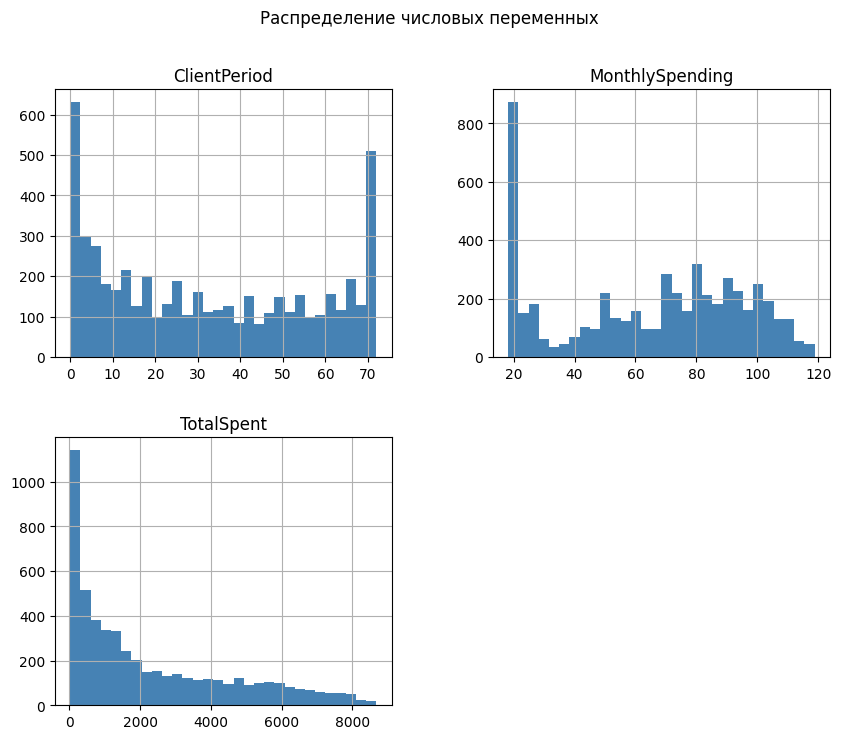

In [10]:
data[num_cols].hist(bins=30, figsize=(10, 8), color='steelblue')
plt.suptitle('Распределение числовых переменных')
plt.show()

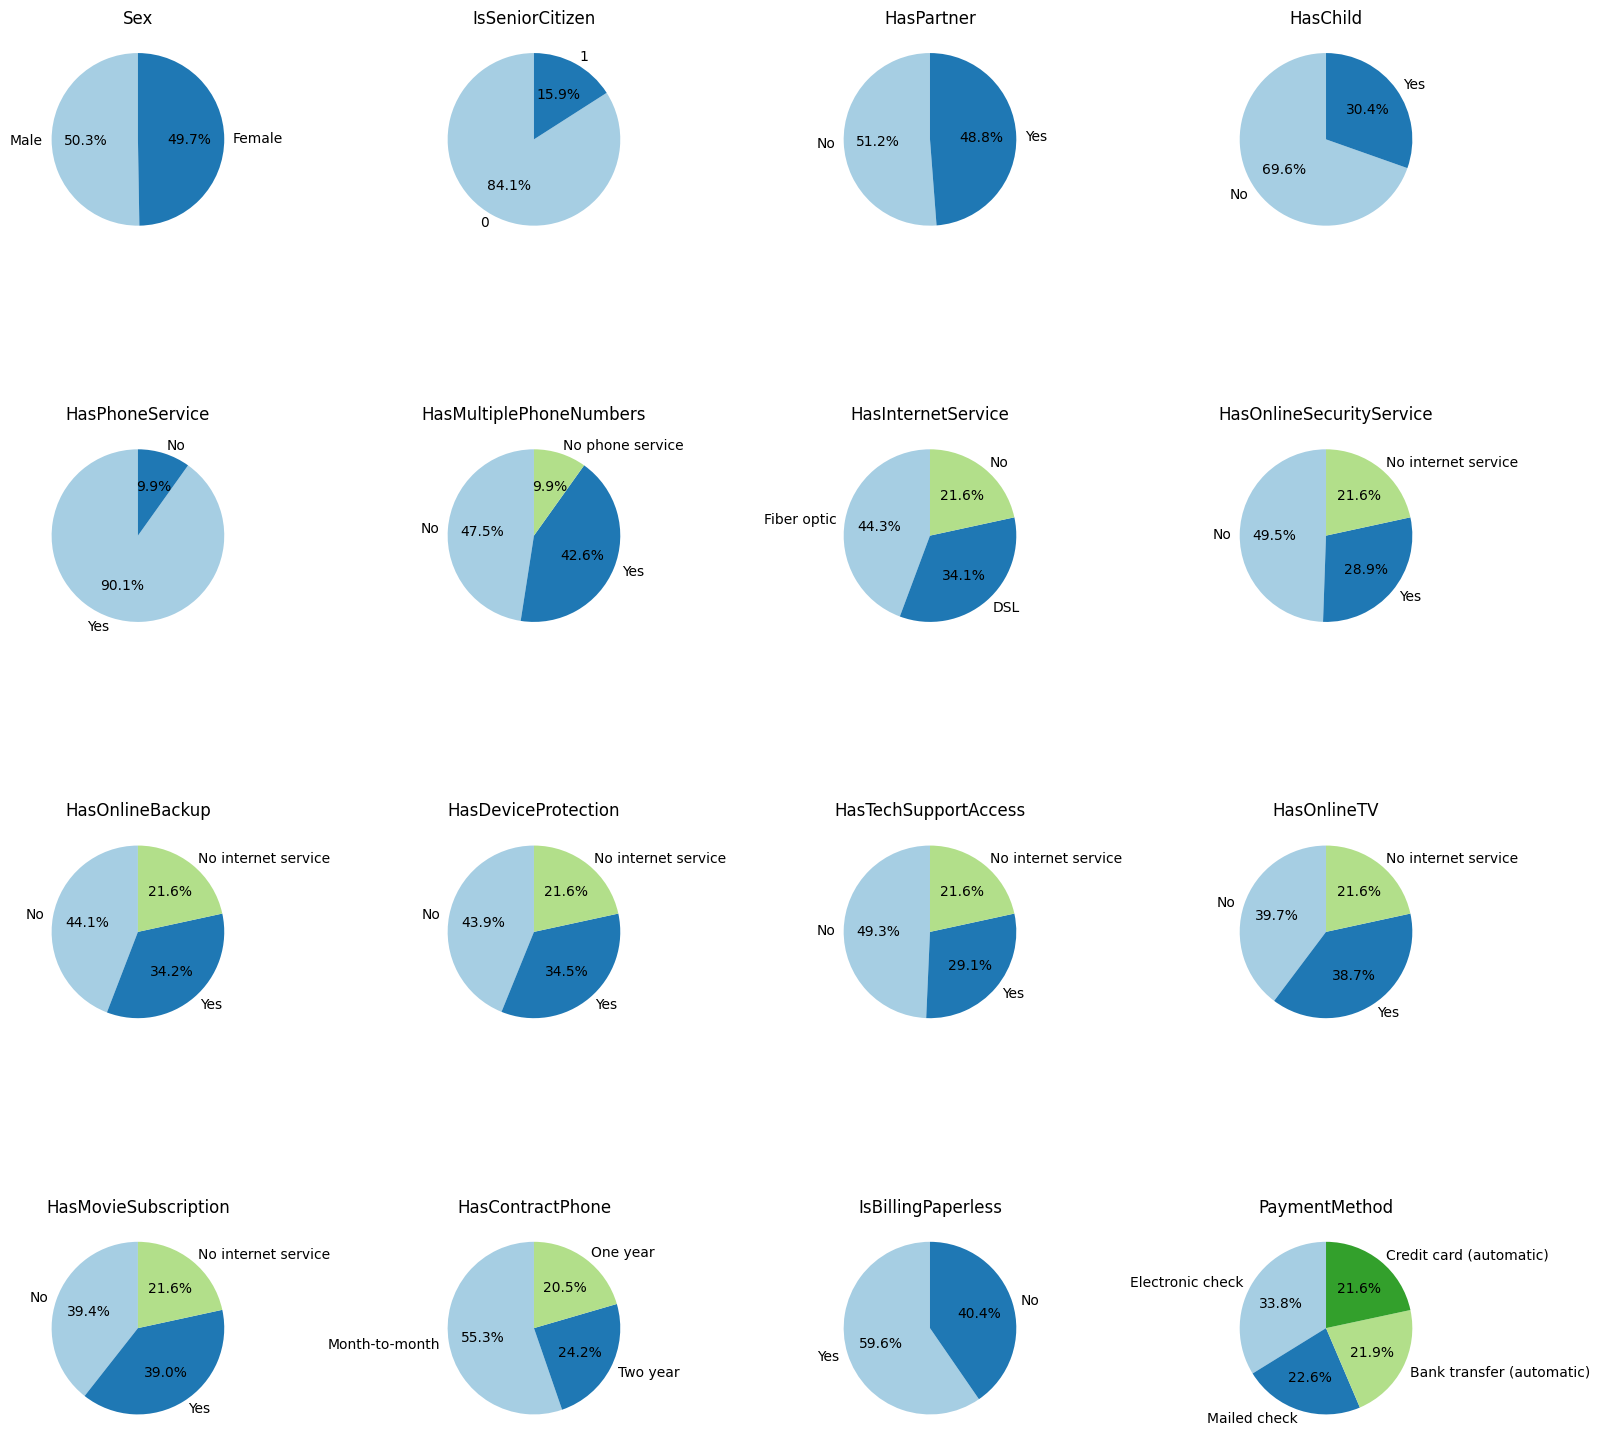

In [11]:
# Анализ категориальных признаков
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, col in enumerate(cat_cols):
    ax = axes[i // 4, i % 4]
    data[col].value_counts().plot.pie(ax=ax, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_title(col)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [12]:
# Распределение целевой переменной
data['Churn'].value_counts()

,count
Churn,
0,3898
1,1384


Классы несбалансированные, accuracy как метрика не подходит

In [13]:
data_original = data.copy() # Сохраним копию

## Применение линейных моделей

1) Обработаем данные для того, чтобы к ним можно было применить LogisticRegression.

2) Подбираем гиперпараметр C и выберем лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC.


In [14]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [15]:
# Отнормируем числовые признаки
scaler = StandardScaler()

# Применение масштабирования к указанным числовым столбцам
data[num_cols] = scaler.fit_transform(data[num_cols])

In [16]:
# OHE  для категориальных
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(data[cat_cols])

one_hot_data = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_cols), index=data.index)

data = pd.concat([data, one_hot_data], axis=1)

data= data.drop(cat_cols, axis=1)

data

,ClientPeriod,MonthlySpending,TotalSpent,Churn,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.920767,-1.505447,-0.557323,0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.613288,-1.294998,-0.184235,0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-1.279005,0.363737,-0.976549,1,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.016173,0.476418,0.123552,0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.124450,1.667856,1.970998,0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,-1.197532,-1.144204,-0.973792,0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5278,0.717084,-0.678565,-0.044743,0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5279,-1.279005,-0.327265,-0.985745,0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5280,-0.138382,0.367051,-0.032922,0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [17]:
X = data.drop('Churn', axis=1)  # Все признаки кроме целевой переменной
y = data['Churn']  # Целевая переменная

pipeline = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))

In [18]:
# Определим сетку гиперпараметров для C
param_grid = {
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001]
}

# Настроим GridSearchCV с кросс-валидацией и метрикой ROC-AUC
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Обучение модели с кросс-валидацией
grid_search.fit(X, y)

# Выводим лучший параметр C
print("Лучший параметр C:", grid_search.best_params_)

# Оцениваем модель на кросс-валидации по метрике ROC-AUC
print("ROC-AUC на кросс-валидации:", grid_search.best_score_)

Лучший параметр C: {'logisticregression__C': 10}
ROC-AUC на кросс-валидации: 0.8450481506512248


## Применение градиентного бустинга

Попробуем получить более точный ответ: для это попробуем градиентный бустинг.

Будет использовать catboost, поэтому не надо кодировать категориальные признаки и нормировать численные признаки (тк для моделей, основанных на деревьях не нужно)

1) Протестируем catboost cо стандартными параметрами.

2) Протестируем разные значения параметров количества деревьев и learning_rate и выберем лучшую по метрике ROC-AUC комбинацию.

In [34]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import time


In [44]:
X = data_original[num_cols + cat_cols]  # Все признаки
y = data_original['Churn']  # Целевая переменная


# Создаем и обучаем модель CatBoost с стандартными параметрами

# Прогнозируем и оцениваем ROC-AUC
base_model = CatBoostClassifier(
    iterations=1000,
    random_seed=42,
    verbose=0,
    cat_features=cat_cols
)

# Оценка базовой модели с кросс-валидацией
cv_scores = cross_val_score(base_model, X, y, cv=5, scoring='roc_auc')
print(f"Средний ROC-AUC со стандартными параметрами: {cv_scores.mean():.4f}")

Средний ROC-AUC со стандартными параметрами: 0.8430


In [49]:
param_grid = {
    'iterations': [100, 300, 500, 1000, 2000],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'l2_leaf_reg': [1, 3, 5]
}

# Настройка поиска с кросс-валидацией
grid_search = GridSearchCV(
    estimator=CatBoostClassifier(cat_features=cat_cols, verbose=0, random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=4,
    n_jobs=-1
)

# Запуск поиска параметров
grid_search.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7e693029b390>,
             n_jobs=-1,
             param_grid={'iterations': [100, 300, 500, 1000, 2000],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.1, 0.05, 0.01, 0.005]},
             scoring='roc_auc', verbose=4)

In [50]:
# Результаты
print(f"Всего проверено комбинаций: {len(grid_search.cv_results_['params'])}")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC: {grid_search.best_score_:.4f}")

Всего проверено комбинаций: 60
Лучшие параметры: {'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Лучший ROC-AUC: 0.8474


Получилось повысить метрику ROC-AUC на 0.0044

# Предсказания

In [53]:
# Сохраняем модель
best_model = grid_search.best_estimator_
best_model.save_model("best_catboost_model.cbm")

In [55]:
# Загрузка тестовых данных и генерация прогноза
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

probs = best_model.predict_proba(X_test)
submission['Churn'] = probs[:, 1]
submission.to_csv('./my_submission.csv', index=False)

Решение направляем в самбмит

Итог на [сабмите](https://www.kaggle.com/competitions/advanced-dls-spring-2021/overview): ROC_AUC=0.85268

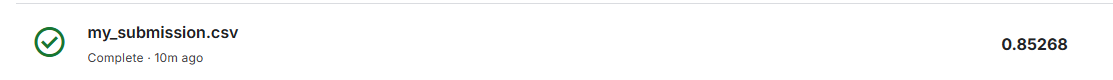